<a href="https://colab.research.google.com/github/ameya1252/5173_HW3/blob/main/hw3_4layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

# Upload a zip file containing data folders
uploaded = files.upload()


Saving Data.zip to Data.zip


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile

In [4]:

# Specify the name of the uploaded zip file
zip_filename = "Data.zip"

# Extract the contents to a specific directory (e.g., /content/data)
extract_path = "/content/data"

# Unzip the file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)



In [5]:
BASE_PATH = "/content/data/Data"

def load_data(data_type="train"):
    images = []
    masks = []

    # Paths
    image_path = os.path.join(BASE_PATH, data_type, "image")
    mask_path = os.path.join(BASE_PATH, data_type, "mask")

    for filename in sorted(os.listdir(image_path)):
        if not filename.endswith('.png'):  # Adjust if your images have a different extension
            continue

        # Read Image
        img = tf.io.read_file(os.path.join(image_path, filename))
        img = tf.image.decode_png(img, channels=1)
        images.append(img)

        # Read corresponding mask
        mask = tf.io.read_file(os.path.join(mask_path, filename))
        mask = tf.image.decode_png(mask, channels=1)
        masks.append(mask)

    return tf.stack(images), tf.stack(masks)

# Load Training and Test Data
train_images, train_masks = load_data(data_type="train")
test_images, test_masks = load_data(data_type="test")

# Normalize Images & Masks to [0, 1]
train_images = tf.cast(train_images, tf.float32) / 255.0
test_images = tf.cast(test_images, tf.float32) / 255.0

train_masks = tf.cast(train_masks, tf.float32) / 255.0
test_masks = tf.cast(test_masks, tf.float32) / 255.0




In [6]:
# U-Net architecture with improvements
def build_unet(input_shape, num_layers=3):
    inputs = Input(input_shape)
    x = inputs
    down_layers = []
    for i in range(num_layers):
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        if i < num_layers - 1:
            x = Dropout(0.5)(x)
        down_layers.append(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

    x = Dropout(0.5)(x)

    for i in range(num_layers - 1, -1, -1):
        x = UpSampling2D((2, 2))(x)
        x = concatenate([x, down_layers[i]])
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

In [7]:
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred):
    smooth = 1e-5
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [8]:
def resize_images(images, target_height, target_width):
    resized_images = []
    for img in images:
        img = tf.image.resize(img, (target_height, target_width))
        resized_images.append(img)
    return tf.stack(resized_images)

# Resize Training and Test Images
target_height = 256  # Update according to your desired image height
target_width = 256   # Update according to your desired image width

resized_train_images = resize_images(train_images, target_height, target_width)
resized_test_images = resize_images(test_images, target_height, target_width)

# Resize Training and Test Masks
resized_train_masks = resize_images(train_masks, target_height, target_width)
resized_test_masks = resize_images(test_masks, target_height, target_width)



# Update Input Shape
input_shape = (target_height, target_width, 1)

# Build and Compile Model
model = build_unet(input_shape, num_layers=4)
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=[dice_coef, iou_coef])

# Train Model
history = model.fit(resized_train_images, resized_train_masks, batch_size=8, epochs=120, validation_split=0.1)


Epoch 1/120
9/9 [==============================] - 36s 639ms/step - loss: 0.7364 - dice_coef: 0.1766 - iou_coef: 0.0969 - val_loss: 1.1689 - val_dice_coef: 0.0120 - val_iou_coef: 0.0060
Epoch 2/120
9/9 [==============================] - 5s 584ms/step - loss: 0.5926 - dice_coef: 0.2218 - iou_coef: 0.1250 - val_loss: 14.7927 - val_dice_coef: 0.0042 - val_iou_coef: 0.0021
Epoch 3/120
9/9 [==============================] - 5s 588ms/step - loss: 0.5138 - dice_coef: 0.2730 - iou_coef: 0.1582 - val_loss: 2.2665 - val_dice_coef: 0.0384 - val_iou_coef: 0.0196
Epoch 4/120
9/9 [==============================] - 5s 588ms/step - loss: 0.4511 - dice_coef: 0.2983 - iou_coef: 0.1754 - val_loss: 3.4585 - val_dice_coef: 0.0053 - val_iou_coef: 0.0027
Epoch 5/120
9/9 [==============================] - 5s 593ms/step - loss: 0.4023 - dice_coef: 0.3278 - iou_coef: 0.1961 - val_loss: 4.2258 - val_dice_coef: 0.1486 - val_iou_coef: 0.0803
Epoch 6/120
9/9 [==============================] - 5s 591ms/step - loss: 

In [9]:
# Resize Test Images and Masks
resized_test_images = resize_images(test_images, target_height, target_width)
resized_test_masks = resize_images(test_masks, target_height, target_width)



# Predict on Resized Test Images
test_preds = model.predict(resized_test_images)

# Evaluate on Resized Test Masks
dice_score = dice_coef(resized_test_masks, test_preds)
iou_score = iou_coef(resized_test_masks, test_preds)

print(f"2 Layers Model - Dice Score: {dice_score}, IoU Score: {iou_score}")


1/1 [==============================] - 10s 10s/step
2 Layers Model - Dice Score: 0.6711077690124512, IoU Score: 0.5050129294395447


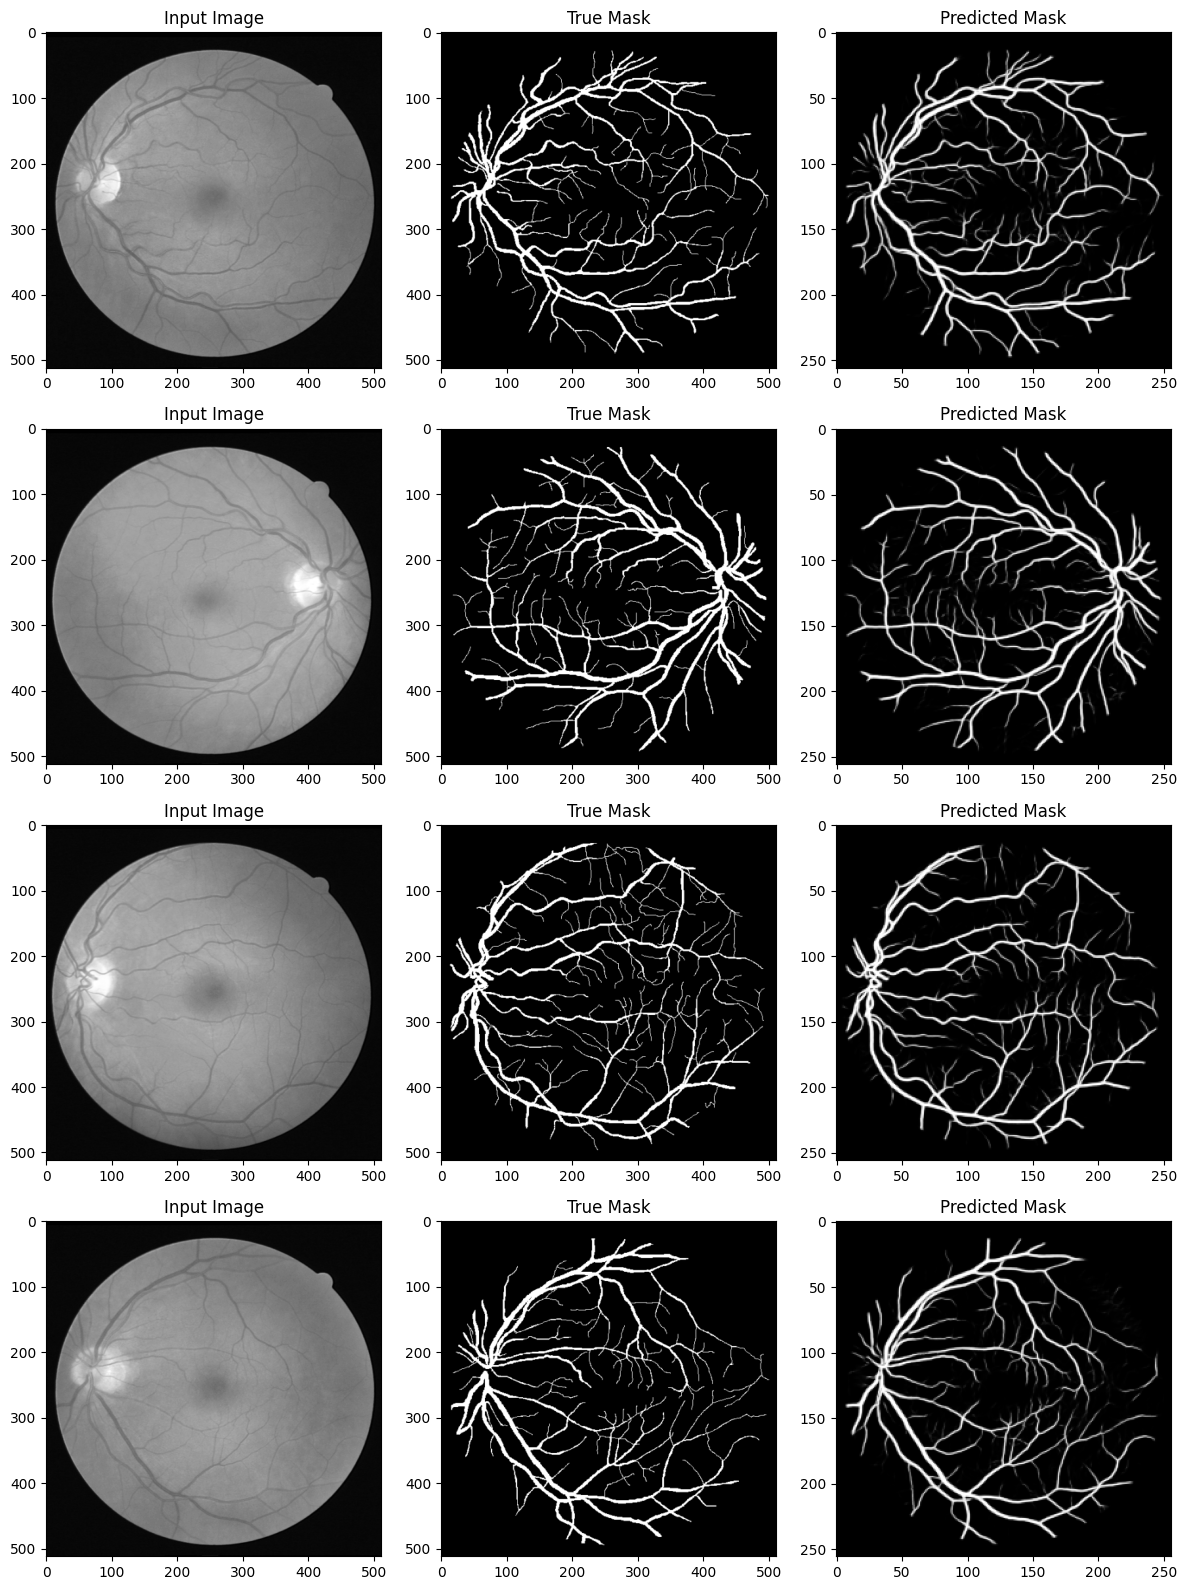

In [10]:
# Visualization
fig, ax = plt.subplots(4, 3, figsize=(12, 16))
for i in range(4):
    ax[i, 0].imshow(test_images[i, ..., 0], cmap="gray")  # Squeeze or index the last dimension
    ax[i, 1].imshow(test_masks[i, ..., 0], cmap="gray")  # Squeeze or index the last dimension
    ax[i, 2].imshow(test_preds[i, ..., 0], cmap="gray")  # Squeeze or index the last dimension

    ax[i, 0].set_title("Input Image")
    ax[i, 1].set_title("True Mask")
    ax[i, 2].set_title("Predicted Mask")

plt.tight_layout()
plt.show()


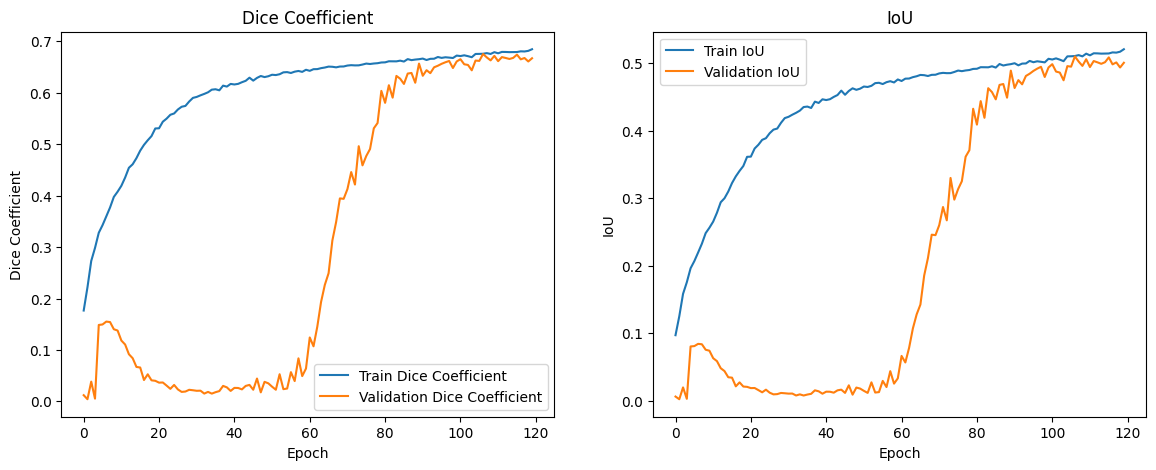

In [11]:
# Plot the training and validation Dice coefficient
plt.figure(figsize=(14, 5))

# Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coef'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

# IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['iou_coef'], label='Train IoU')
plt.plot(history.history['val_iou_coef'], label='Validation IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.show()
